In [77]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [78]:
file_name = "../multi_seed_results/spectrum/s_8192_feat_fp_64b_svd_ind_full_dataset.npy"
with open(file_name, "rb") as f:
    spectrum = np.load(f) 
spectrum = spectrum[:int(file_name.split("/")[-1].split("_")[1] ) ]
print spectrum, spectrum.size

[  1.45426358e+04   3.08469761e+02   2.33630567e+02 ...,   4.61121465e-07
   4.58831976e-07   4.53135714e-07] 8192


# binary continuous rounding approach 

In [129]:
def get_bits(spectrum, s, upper_bound=None):
    assert type(upper_bound) == int
    nbits = np.maximum(np.log2(spectrum) + s, np.zeros(spectrum.size) )
    if upper_bound != None:
        nbits = np.minimum(nbits, upper_bound * np.ones(spectrum.size) )
    nbits[nbits!=0] = 2**(np.floor(np.log2(nbits[nbits!=0] ) ) )
#     return 2**(np.floor(np.log2(nbits) ) ).astype(np.int)
#     return np.exp(np.log2(nbits) ).astype(np.int)
#     return np.floor(nbits)
    return nbits.astype(np.int)
    
def get_n_fp_feat(spectrum, s, upper_bound=None):
    nbits = get_bits(spectrum, s, upper_bound)
    n_fp_feat = nbits.astype(np.float) / 32.0
    return np.sum(n_fp_feat), nbits    

In [163]:
def binary_search_bits_assignment(spectrum, n_fp_feat_budget, left=-100.0, right=100.0, tolerance=1e-6, upper_bound=None):
    # upper_bound is the upper bound of number of bits
    n_fp_feat = 0
    best_n_fp_feat = 0
    best_sol = None
    while right - left >= tolerance:
        middle = (left + right) / 2.0
        n_fp_feat, nbits = get_n_fp_feat(spectrum, middle, upper_bound)
        if n_fp_feat == n_fp_feat_budget:
            print("found exact assignment plan", nbits)
            best_sol = nbits
            best_n_fp_feat = n_fp_feat
            break
        elif n_fp_feat < n_fp_feat_budget:
            left = middle
        else:
            right = middle
        if best_n_fp_feat < n_fp_feat and n_fp_feat < n_fp_feat_budget:
            best_sol = nbits
            best_n_fp_feat = n_fp_feat
#         print("testing middle = ", middle, " n_fp_feat ", n_fp_feat)
    print("best solution, memory budget ", best_n_fp_feat, " / ", n_fp_feat_budget)
    return best_sol

### sanity check full budget + full precision results

In [164]:
n_fp_feat_budget=8192
search_left = -200.0
search_right = 200.0
tolerance=1e-6
upper_bound = 32

In [165]:
nbits = binary_search_bits_assignment(spectrum, n_fp_feat_budget, 
                                      search_left, search_right,
                                      tolerance, upper_bound)
assert np.max(nbits) == upper_bound
assert np.min(nbits) == upper_bound

('found exact assignment plan', array([32, 32, 32, ..., 32, 32, 32]))
('best solution, memory budget ', 8192.0, ' / ', 8192)


In [166]:
# _ = plt.hist(nbits, bins=32)

### sanity check full 

In [167]:
n_fp_feat_budget=1024
search_left = -200.0
search_right = 200.0
tolerance=1e-6
upper_bound = 32

In [168]:
nbits = binary_search_bits_assignment(spectrum, n_fp_feat_budget, 
                                      search_left, search_right,
                                      tolerance, upper_bound)
print nbits, np.sum(nbits) / 32.0
assert np.sum(nbits) / 32.0 <= n_fp_feat_budget

('best solution, memory budget ', 1023.9375, ' / ', 1024)
[32 16 16 ...,  0  0  0] 1023.9375


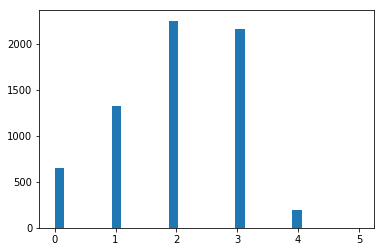

In [169]:
_ = plt.hist(np.log2(nbits[nbits!=0]), bins=32)

# submodular optimization under cardinality constraints